# Image Segmentation 

Arnoldus P.b
2602136890

Untuk kasus ini saya akan memilih Image Segmentattion. Image Segmentation singkatnya merupakan sebuah teknik untuk mempetakan gambar. Dimana Objek yang terdeteksi akan memberikan warna yang kontras. Disini saya kana memilih KERAS dalam proses image segmentation.

Penjelasan Dataset:
Data set yang saya pilih adalah gambar berupa hewan hewan peliharaan yang terdiri dari 7000 lebih images(nanti ada jumlahnya saat di read Hehe :>)

# Libraries

In [1]:

import os
import numpy as np
import random

#Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Load data
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

#Modelling and giving result
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers

# Load Dataset

In [2]:
# Define directories and parameters
input_directory = "images"
target_directory = "annotations/trimaps"
image_size = (160, 160)
class_count = 3
batch_size = 16

# Gather and sort input image paths
input_image_paths = sorted(
    [
        os.path.join(input_directory, file_name)
        for file_name in os.listdir(input_directory)
        if file_name.endswith(".jpg")
    ]
)

# Gather and sort target image paths
target_image_paths = sorted(
    [
        os.path.join(target_directory, file_name)
        for file_name in os.listdir(target_directory)
        if file_name.endswith(".png") and not file_name.startswith(".")
    ]
)

# Print the total number of samples
print("Total number of samples:", len(input_image_paths))

Total number of samples: 7390


Disini kita mendapat 7390 images. Kita harus memisah dan menggabungkan seluruh image yang berakhiran jpg dan png menjadi 1 alhasil mendapat 7390 images.

# Sample Of Dataset

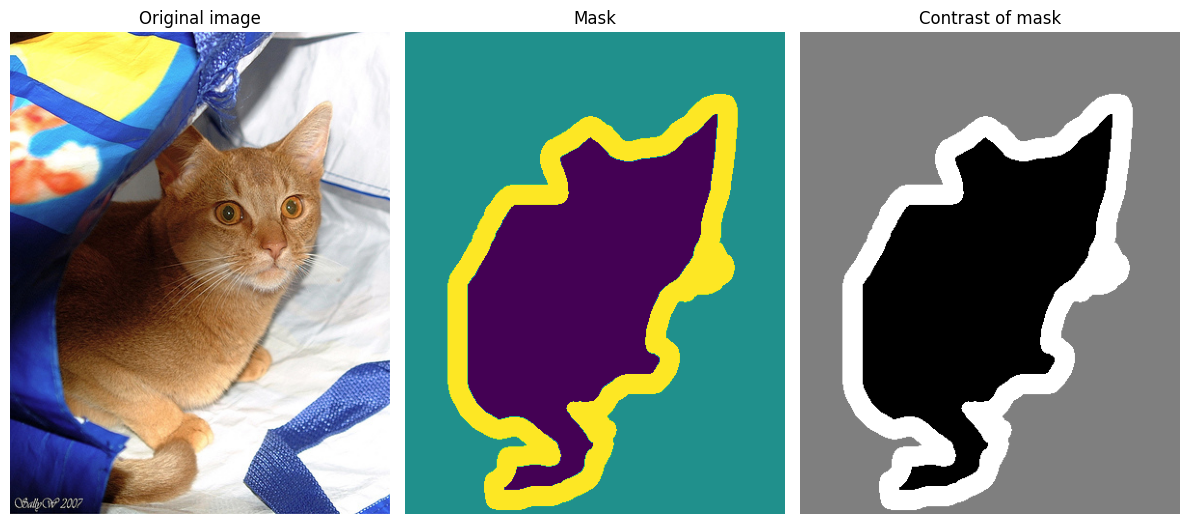

In [3]:
# Ensure to use the correct paths
i = 2
figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

# Display the original image
ax[0].imshow(mpimg.imread(input_image_paths[i]))
ax[0].set_title("Original image")
ax[0].axis('off')

# Display the mask
ax[1].imshow(mpimg.imread(target_image_paths[i]))
ax[1].set_title("Mask")
ax[1].axis('off')

# Display the contrast-adjusted mask
ax[2].imshow(ImageOps.autocontrast(load_img(target_image_paths[i])))
ax[2].set_title("Contrast of mask")
ax[2].axis('off')

plt.tight_layout()
plt.show()

Disini didisplay sebuah gambar kucing , ada masking dan contrast mask yang diberikan.
Meow:3

# Makin Batches and Load for train

In [4]:
class PetsDataset(keras.utils.Sequence):
    """Helper class to iterate over data as Numpy arrays."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, index):
        """Returns a tuple (input, target) corresponding to the batch index."""
        start = index * self.batch_size
        end = start + self.batch_size
        batch_input_img_paths = self.input_img_paths[start:end]
        batch_target_img_paths = self.target_img_paths[start:end]

        # Initialize input and target batches
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")

        # Load input images
        for i, img_path in enumerate(batch_input_img_paths):
            img = load_img(img_path, target_size=self.img_size)
            x[i] = img

        # Load target images
        for i, img_path in enumerate(batch_target_img_paths):
            img = load_img(img_path, target_size=self.img_size, color_mode="grayscale")
            y[i] = np.expand_dims(img, 2)
            # Adjust labels from 1, 2, 3 to 0, 1, 2
            y[i] -= 1

        return x, y


# Modelling

In [5]:
def get_model(img_size, num_classes):
    # Define input layer
    inputs = keras.Input(shape=img_size + (3,))


    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Store the first block's activation

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Store next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Store next residual

    # Output layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Create model
    model = keras.Model(inputs, outputs)
    return model

# Clear any previous models and build the new one
keras.backend.clear_session()
img_size = (160, 160)
num_classes = 3
model = get_model(img_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 80, 80,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 80, 80,    │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 80, 80,    │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 40,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 40, 40,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 40, 40,    │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

# Splitting Images

In [6]:
import random

# Define the number of validation samples
val_samples = 1108  # 15% of the total samples

# Shuffle input and target image paths with the same random seed
random.seed(1822)
random.shuffle(input_image_paths)
random.seed(1822)
random.shuffle(target_image_paths)

# Split into training and validation sets
train_input_img_paths = input_image_paths[:-val_samples]
train_target_img_paths = target_image_paths[:-val_samples]
val_input_img_paths = input_image_paths[-val_samples:]
val_target_img_paths = target_image_paths[-val_samples:]

# Instantiate data sequences for each split
train_gen = PetsDataset(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = PetsDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)


# Train Using Keras

In [7]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available: 0


In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Compile the model
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Define callbacks
callbacks = [
    ModelCheckpoint("pets_segmentation.keras", save_best_only=True)
]

# Define number of epochs
epochs = 30

# Train the model
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


Epoch 1/30


c:\Users\USER\Documents\DeepLearning\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


392/392 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.6843 - loss: 1.2678 - val_accuracy: 0.5874 - val_loss: 1.6596
Epoch 2/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 347s 880ms/step - accuracy: 0.8123 - loss: 0.4754 - val_accuracy: 0.8255 - val_loss: 0.4368
Epoch 3/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.8420 - loss: 0.4024 - val_accuracy: 0.8467 - val_loss: 0.3910
Epoch 4/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 358s 911ms/step - accuracy: 0.8577 - loss: 0.3626 - val_accuracy: 0.8480 - val_loss: 0.3845
Epoch 5/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 481s 1s/step - accuracy: 0.8716 - loss: 0.3270 - val_accuracy: 0.8612 - val_loss: 0.3657
Epoch 6/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 526s 1s/step - accuracy: 0.8813 - loss: 0.3009 - val_accuracy: 0.8464 - val_loss: 0.4008
Epoch 7/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 387s 982ms/step - accuracy: 0.8911 - loss: 0.2756 - val_accuracy: 0.8651 - val_loss: 0.3471
Epoch 8/30
392/392 ━━━━━━━━━━━━━━━━━━━━ 273s 697ms/step - accuracy: 0.8975 - loss: 0.2569 - val_acc

Note: Akurasi lumayan bagus, namun waktu tidak efisien dalam training model

Accuracy (Akurasi): Nilai akurasi mencerminkan seberapa baik model dapat mengklasifikasikan data yang diberikan dengan benar. Semakin tinggi nilai akurasi, semakin baik model dalam memprediksi label yang benar.

Loss (Kehilangan): Nilai kehilangan (loss) mengindikasikan seberapa baik atau buruk performa model dalam memperkirakan nilai yang sebenarnya. Semakin rendah nilai loss, semakin baik model dalam melakukan prediksi yang akurat.

Validation Accuracy (Akurasi Validasi): Akurasi validasi menunjukkan performa model pada data validasi yang terpisah dari data pelatihan. Ini penting untuk memastikan bahwa model tidak hanya melakukan overfitting pada data pelatihan tetapi juga dapat umum digunakan pada data baru.

Validation Loss (Kehilangan Validasi): Kehilangan validasi adalah kehilangan yang dihitung pada data validasi. Tujuannya adalah untuk memastikan bahwa model tidak hanya mempelajari detail-detail kecil dari data pelatihan tetapi dapat melakukan generalisasi yang baik pada data yang belum pernah dilihat sebelumnya.

Tren Pelatihan: Dari keluaran yang Anda berikan, terlihat bahwa baik akurasi maupun kehilangan (loss) pada data pelatihan dan validasi menunjukkan tren yang positif. Akurasi terus meningkat sementara loss terus menurun, yang menandakan bahwa model Anda belajar dengan baik dari data.

Kinerja pada Epoch Akhir: Pada akhir pelatihan, model mencapai akurasi sekitar 95.76% pada data pelatihan dan 88.07% pada data validasi. Loss pada data validasi adalah sekitar 0.45, yang menunjukkan bahwa model memiliki kinerja yang baik dalam memprediksi kelas dari gambar-gambar yang belum pernah dilihat sebelumnya.

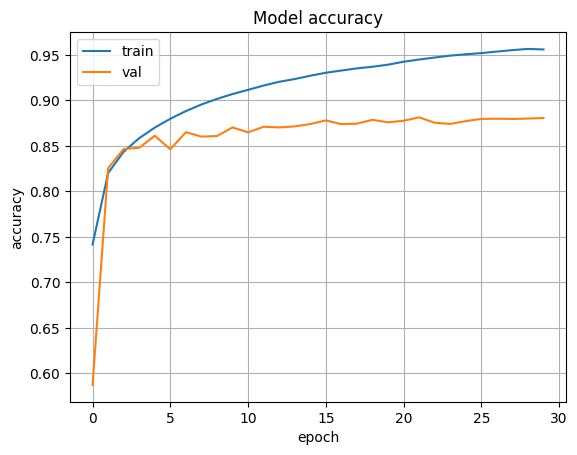

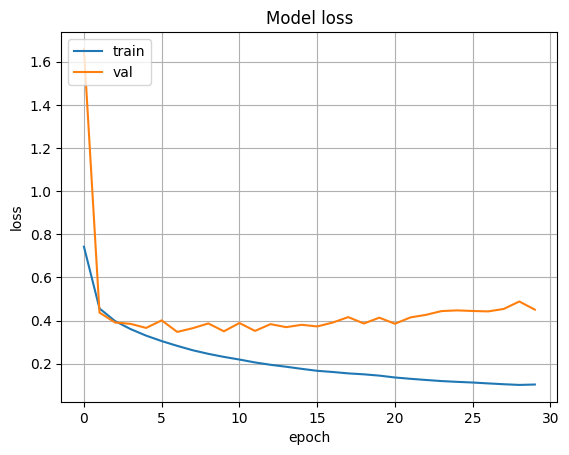

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

Dalam Grafil Loss disini X= Epoch Y= Loss


Dalam Grafik Model loss disini bisa dilihat bahwa saat training data semakin epoch bertambah grafiknya menurun. Berarti selama proses model semakin baik kinerjanya. Diawal loss terlihat tajam namun seiring bertambahnya epochsemakin baik dalam menyesuaikan kestabilannya


Dalam Grafik Accuracy disini 
X=Epoch
Y=Accuracy

Disini bisa dilihat semakin bertambhanya epoch grafik semakin meningkat yang berati tingkat akurasi yang dihasilkan dalam setiap epoch akan semakin baik seiringbertambahnya epoch.

Kesimpulan model:
Keduanya berjalan dengan baik namun disini ada indikasi overfitting karena perbedaan performa antara data belatihan dan data valiadasi terutama dalam grafik loss.

In [14]:
# Generate predictions for all images in the validation set
val_gen = PetsDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step


In [12]:
def show_prediction_mask(index):
    """Utility function to visualize a model's prediction."""
    # Get the predicted mask for the given index
    predicted_mask = np.argmax(val_preds[index], axis=-1)
    # Expand the mask dimensions
    predicted_mask = np.expand_dims(predicted_mask, axis=-1)
    # Convert the mask to an image and enhance contrast
    predicted_image = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(predicted_mask))
    return predicted_image


# Test Image

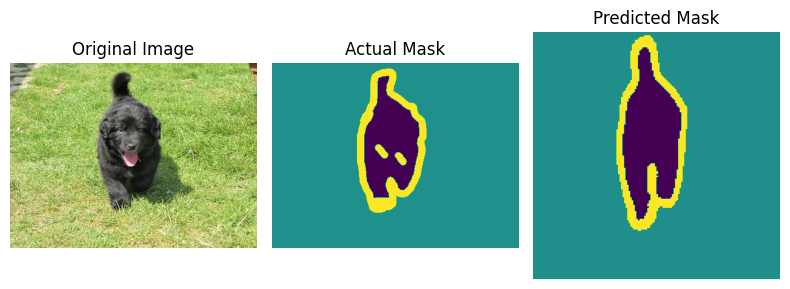

In [13]:
#Display 1 random image
index = 150
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))

# Display the original image
axes[0].imshow(mpimg.imread(val_input_img_paths[index]))
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display the actual mask
axes[1].imshow(mpimg.imread(val_target_img_paths[index]))
axes[1].set_title("Actual Mask")
axes[1].axis('off')

# Display the predicted mask
axes[2].imshow(show_prediction_mask(index))
axes[2].set_title("Predicted Mask")
axes[2].axis('off')

# Adjust layout for better display
plt.tight_layout()


Berikut adalah analisis dari gambar yang diunggah dalam konteks tugas segmentasi citra, yang bertujuan untuk memisahkan objek (dalam hal ini anjing) dari latar belakang:

1. **Gambar Kiri (Original Image)**
   - Ini adalah citra asli yang menampilkan seekor anjing hitam berjalan di atas rumput hijau.

2. **Gambar Tengah (Actual Mask)**
   - Ini adalah masker sebenarnya atau ground truth yang menunjukkan bagian dari citra asli yang merupakan objek (anjing) dan bagian yang bukan objek.
   - Warna ungu menunjukkan area di mana objek (anjing) berada, kuning menandakan batas objek, dan hijau mungkin menunjukkan latar belakang.

3. **Gambar Kanan (Predicted Mask)**
   - Ini adalah masker yang diprediksi oleh model segmentasi.
   - Warna ungu menunjukkan area yang model identifikasi sebagai objek (anjing), sementara kuning menunjukkan batas objek yang diprediksi.

**Analisis:**

- **Keselarasan dengan Masker Sebenarnya:**
  - Prediksi model tampaknya mampu mengenali objek utama (anjing) dengan baik dan membedakannya dari latar belakang.
  - Model berhasil menangkap bentuk umum dan batas objek, meskipun ada beberapa perbedaan dengan masker sebenarnya.
  - Ada beberapa area di mana prediksi model lebih halus atau tidak sejelas masker sebenarnya.

- **Perbedaan Utama:**
  - Terdapat perbedaan di sekitar kaki dan ekor anjing antara masker sebenarnya dan prediksi model, menunjukkan tantangan dalam menangani detail halus atau bagian yang lebih kompleks dari objek.
  - Masker prediksi menunjukkan batas yang lebih tegas dan konsisten di sekitar objek, sementara masker sebenarnya memiliki detail yang lebih halus dan mungkin lebih variatif.

**Kesimpulan:**
- Model segmentasi ini secara umum efektif dalam mengenali objek utama (anjing), namun masih ada ruang untuk perbaikan terutama dalam menangani detail yang lebih kecil atau kompleks.
- Untuk meningkatkan performa, model dapat mendapatkan manfaat dari lebih banyak data pelatihan atau penerapan teknik augmentasi data untuk menangani variasi bentuk dan detail objek yang lebih luas.

Urgency Case dan Future direction

Image segmentation sangat berguna untuk diimplementasikan dalam banyak hal. Dari keamanan, ataupun bisa menckup hal hal yang tidak terpikir sebelumnya.

Contoh :
Otomatisasi Industri: Dalam industri, seperti pengolahan citra pada lini produksi, segmentasi digunakan untuk memisahkan objek dari latar belakang, menghitung objek, dan memantau kualitas produk.

Analisis Big Data: Dengan pertumbuhan besar dalam data gambar, seperti media sosial, segmentasi membantu dalam pencarian, pengelompokan, dan analisis konten visual dalam skala besar.

Karena metode ini sangat berguna untuk keseharian masyarakat apabila kita dapat mengimplementasikannya dengan baik.

Akhirkata terimakasih mohon maaf apa bila ada kata kata yang kurang atau ada poin yang terlewat
Terimakasih :).